In [1]:
import copy
import gym
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
class Swing(gym.Env):
    def __init__(self, target=np.pi, l_min=1, omega_0=-0.01):
        super(Swing, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -10, 0]), high=np.array([2 * np.pi, 10, 2])  # phi, phi dot, L
        )

        self.action_space = gym.spaces.Box(
            low=np.array([-1, -1]), high=np.array([1, 1])
        )
        self.tau = np.sqrt(l_min / 9.81) / 4
        self.l_min = l_min
        self.l_max = 1.5 * l_min
        self.omega_0 = omega_0
        self.target = target
        self.time = 0
        self.pumps = 0
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        self.L = [l_min]
        self.a_history = []
        self.d_history = []

    def fun(self, t, y, a, d, g=9.81):
        y0_dot = y[1]
        y1_dot = (
            -2
            * y[1]
            / y[2]
            * (
                -(y[2] - self.l_min) / self.tau
                + ((self.l_max - self.l_min) / self.tau) * a * np.cos(y[0] + d)
            )
        ) - (g / y[2]) * np.sin(
            y[0]
        )  # + (1/y[2])*y[1] #drag term
        y2_dot = (
            -(y[2] - self.l_min) / self.tau
            + (self.l_max - self.l_min) * a * np.cos(y[0] + d) / self.tau
        )
        y_dot = np.hstack((y0_dot, y1_dot, y2_dot))
        return y_dot

    def step(self, action):
        a = action[0]
        self.a_history.append(a)
        d = np.pi * action[1]
        self.d_history.append(d)
        sol = si.solve_ivp(
            self.fun,
            [self.time, self.time + self.tau],
            y0=[self.phi[-1], self.phi_dot[-1], self.L[-1]],
            args=(a, d),
        )
        # phi = np.mod(sol.y[0][-1], 2 * np.pi)
        phi = np.mod(sol.y[0], 2 * np.pi)
        self.phi.extend(list(phi[1:]))
        # phi_dot = sol.y[1][-1]
        phi_dot = sol.y[1]
        self.phi_dot.extend(list(phi_dot[1:]))
        # L = sol.y[2][-1]
        L = sol.y[2]
        self.L.extend(list(L[1:]))
        #state = np.array([phi[-1], phi_dot[-1]])
        state = np.array([phi[-1], phi_dot[-1], L[-1]])
        if np.isclose(state[0], self.target, rtol=0.05):
            reward = 10
            done = True
        elif self.pumps > 1000:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        info = {}
        self.time += self.tau
        self.pumps += 1
        return state, reward, done, info

    def reset(self):
        self.time = 0
        self.pumps = 0
        self.L = [self.l_min]
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        # state = np.array([self.phi[-1], self.phi_dot[-1]])
        state = np.array([self.phi[-1], self.phi_dot[-1], self.L[-1]])
        self.a_history.clear()
        self.d_history.clear()
        return state

    def render(self):
        pass

In [3]:
env = Swing(target=np.pi)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2.5e5)

/Users/iandavenport/Desktop/research/chameleon/venv/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 283      |
|    ep_rew_mean     | -272     |
| time/              |          |
|    fps             | 1002     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 290          |
|    ep_rew_mean          | -279         |
| time/                   |              |
|    fps                  | 847          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0052344967 |
|    clip_fraction        | 0.0297       |
|    clip_range           | 0.2          |
|    en

In [4]:
model.save("fullswingup")
del model
model = PPO.load("fullswingup.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [5]:
obs = env.reset()
done = False
i = 0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    i += 1

a_actions = copy.deepcopy(env.a_history)
a_actions.insert(0, 0)

d_actions = copy.deepcopy(env.d_history)
d_actions.insert(0, 0)

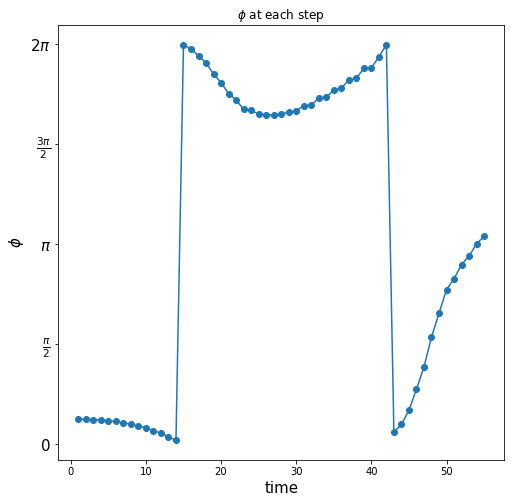

In [6]:
times = np.linspace(1, len(env.phi), len(env.phi))
plt.figure(figsize=(8, 8))
plt.plot(times, env.phi, "-o")
plt.title(r"$\phi$ at each step")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"$\phi$", fontsize=15)
plt.yticks(
    np.linspace(0, 2 * np.pi, 5),
    labels=["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"2$\pi$"],
    fontsize=15,
)
plt.show()

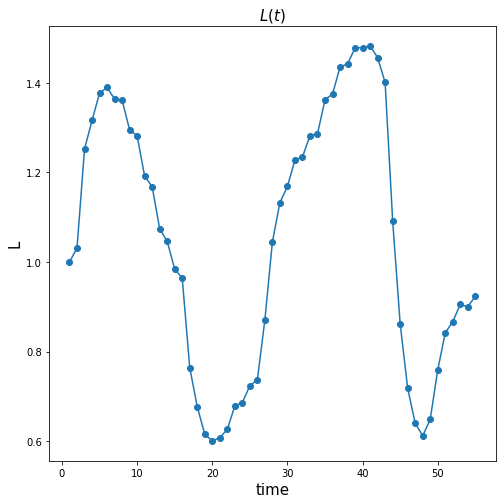

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(times, env.L, "-o")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"L", fontsize=15)
plt.title(r"$L(t)$", fontsize=15)
plt.show()

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.plot(times, a_actions, "-o")
# plt.xlabel("time", fontsize=15)
# plt.ylabel("a", fontsize=15)
# plt.title(r"$a(t)$", fontsize=15)
# plt.show()

In [ ]:
# f, ax = plt.subplots(figsize=(10, 10))

# ax.plot(times, d_actions, "-o")
# # ax.yaxis.set_major_formatter(tck.FormatStrFormatter('$\pi$'))
# # ax.yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# # plt.plot(times, d_actions[-23:], "-o")
# ax.set_xlabel("time", fontsize=15)
# ax.set_ylabel(r"$\delta$", fontsize=15)
# ax.set_title(r"$\delta(t)$", fontsize=15)
# ax.set_yticks(
#     np.linspace(-np.pi, np.pi, 3), labels=[r"-$\pi$", r"0", r"$\pi$"], fontsize=15
# )
# plt.show()

$$(\phi, \dot{\phi})$$

In [8]:
x_pos = np.array(env.L) * np.sin(env.phi)
y_pos = -np.array(env.L) * np.cos(env.phi)
ref_x = np.array(env.l_max) * np.sin(env.phi)
ref_y = -np.array(env.l_max) * np.cos(env.phi)
pos_arr = np.vstack((x_pos, y_pos))
ref_pos_arr = np.vstack((ref_x, ref_y))
np.save("positions_arr", pos_arr)
np.save("ref_pos_arr", ref_pos_arr)